# Sentiment Analysis of Covid-19 Booster Shot in Regards to Herd Immunity

# 1. Import of Libraries

In [1]:
import tweepy
import pandas as pd
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from wordcloud import WordCloud
import nltk 
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from simpletransformers.classification import ClassificationModel

import random
import torch
from sklearn.model_selection import KFold

import logging
from pathlib import Path

import twitter_credentials as tc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kames\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Data Collection, Preprocessing and Cleaning

## 2.1 Twitter API Setup

In [2]:
auth = tweepy.OAuthHandler(tc.api_key, tc.api_secret_key)

auth.set_access_token(tc.access_token, tc.access_token_secret)

In [3]:
api = tweepy.API(auth, wait_on_rate_limit=True)

In [21]:
search_words = "coronavirus OR covid OR pandemic OR covid19 OR lockdown AND herd immunity OR collective immunity OR immunity OR booster"

date_since = "2022-06-01"
date_until = "2022-07-01"

my_search = search_words + " -filter:retweets" + " -filter:replies"

In [22]:
tweets = tweepy.Cursor(api.search_tweets,
                       q=my_search,
                       lang="en",
                       tweet_mode='extended',
                       until=date_until).items(1000)

In [23]:
%%time
tweet_info = [[tweet.id_str,tweet.created_at,tweet.user.location,tweet.full_text] for tweet in tweets]

CPU times: total: 1.36 s
Wall time: 13 s


In [24]:
df = pd.DataFrame(data=tweet_info, columns=['tweet_id_str','date_time','location','tweet_text'])

df

tweet_id_str                 date_time  \
0    1542639871981920256 2022-06-30 22:43:01+00:00   
1    1542621979496402952 2022-06-30 21:31:55+00:00   
2    1542613809285795840 2022-06-30 20:59:27+00:00   
3    1542601823202119681 2022-06-30 20:11:49+00:00   
4    1542600827730157568 2022-06-30 20:07:52+00:00   
..                   ...                       ...   
275  1540160082440241152 2022-06-24 02:29:13+00:00   
276  1540143064475639808 2022-06-24 01:21:35+00:00   
277  1540139913567301633 2022-06-24 01:09:04+00:00   
278  1540138957220073473 2022-06-24 01:05:16+00:00   
279  1540138337050062848 2022-06-24 01:02:48+00:00   

                        location  \
0              Pennsylvania, USA   
1                  New York, USA   
2                     Wirral, UK   
3    BC, Canada(formerly, Calif)   
4                                  
..                           ...   
275                New York, USA   
276              California, USA   
277                 Portland, OR   
278            St Petersburg, FL   
279    Seattle, WA, USA (mostly)   

                                            tweet_text  
0    Interview with renowned Oxford epidemiologist ...  
1    RNA vaccine covid19 vaccine\n\n especially dan...  
2    With freedom day fast approaching, the Governm...  
3    Opinion | How one doctor wrecked the pandemic ...  
4    Marching between Skippy and James Topp is Dr P...  
..                                                 ...  
275  https://t.co/ZvMEBhZgcT:”The Johnson governmen...  
276  How hiring the wrong medical “expert” derailed...  
277  How hiring the wrong medical “expert” derailed...  
278  Trump's COVID Task Force Leader Pushed Back on...  
279  How hiring the wrong medical “expert” derailed...  

[280 rows x 4 columns]

In [25]:
# Saving data to a csv file
df.to_csv('data.csv',index=False)

In [26]:
# Reading csv file
datas = pd.read_csv("data.csv")
df = pd.DataFrame(data=datas, columns=['tweet_id_str','date_time','location','tweet_text'])

df

tweet_id_str                  date_time  \
0    1542639871981920256  2022-06-30 22:43:01+00:00   
1    1542621979496402952  2022-06-30 21:31:55+00:00   
2    1542613809285795840  2022-06-30 20:59:27+00:00   
3    1542601823202119681  2022-06-30 20:11:49+00:00   
4    1542600827730157568  2022-06-30 20:07:52+00:00   
..                   ...                        ...   
275  1540160082440241152  2022-06-24 02:29:13+00:00   
276  1540143064475639808  2022-06-24 01:21:35+00:00   
277  1540139913567301633  2022-06-24 01:09:04+00:00   
278  1540138957220073473  2022-06-24 01:05:16+00:00   
279  1540138337050062848  2022-06-24 01:02:48+00:00   

                        location  \
0              Pennsylvania, USA   
1                  New York, USA   
2                     Wirral, UK   
3    BC, Canada(formerly, Calif)   
4                            NaN   
..                           ...   
275                New York, USA   
276              California, USA   
277                 Portland, OR   
278            St Petersburg, FL   
279    Seattle, WA, USA (mostly)   

                                            tweet_text  
0    Interview with renowned Oxford epidemiologist ...  
1    RNA vaccine covid19 vaccine\n\n especially dan...  
2    With freedom day fast approaching, the Governm...  
3    Opinion | How one doctor wrecked the pandemic ...  
4    Marching between Skippy and James Topp is Dr P...  
..                                                 ...  
275  https://t.co/ZvMEBhZgcT:”The Johnson governmen...  
276  How hiring the wrong medical “expert” derailed...  
277  How hiring the wrong medical “expert” derailed...  
278  Trump's COVID Task Force Leader Pushed Back on...  
279  How hiring the wrong medical “expert” derailed...  

[280 rows x 4 columns]

In [27]:
def clean_text(text): 
    """
    A function to clean the tweet text
    """
    #Remove hyper links
    text = re.sub(r'https?:\/\/\S+', ' ', text)
    
    #Remove @mentions
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    
    #Remove anything that isn't a letter, number, or one of the punctuation marks listed
    text = re.sub(r"[^A-Za-z0-9#'?!,.]+", ' ', text)   
    
    return text

In [28]:
data_pp = pd.read_csv("data.csv")
df_pp = pd.DataFrame(data=data_pp, columns=['tweet_id_str','date_time','location','tweet_text'])

In [29]:
df_pp['tweet_text']=df_pp['tweet_text'].apply(clean_text)
df_pp['tweet_text']=df_pp['tweet_text'].str.lower()

In [30]:
stopwords = stopwords.words("english")
my_stopwords = ['coronavirus','covid','pandemic','covid19','lockdown','amp','via','herd immunity','collective immunity', 'immunity', 'booster']
stopwords.extend(my_stopwords)

In [31]:
def remove_stopwords(text):
    """
    A function to remove stop words
    """
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords]
    filtered_text = ' '.join(filtered_tokens)    
    
    return filtered_text

In [32]:
df_pp['tweet_text']=df_pp['tweet_text'].apply(remove_stopwords)
# Saving preprocessed data to a csv
df_pp.to_csv("preprocesseddata.csv")

## 2.2 Word Cloud With Stopwords

<Figure size 1440x720 with 0 Axes>

(-0.5, 499.5, 399.5, -0.5)

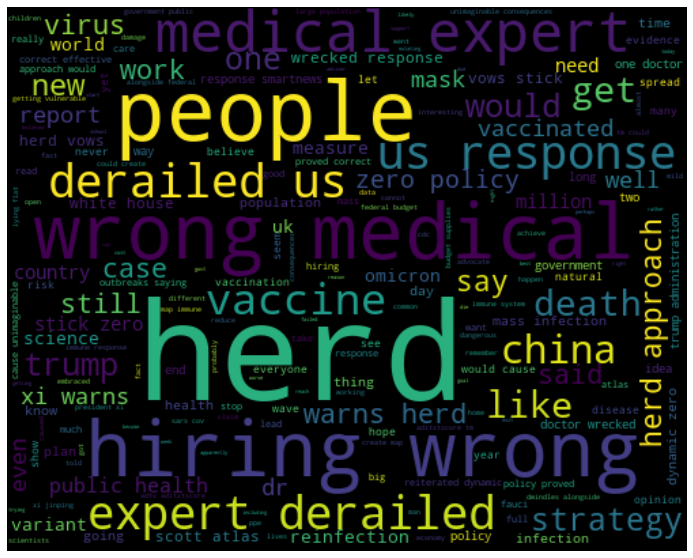

In [33]:
all_words = ' '.join( [data for data in df_pp['tweet_text']])
word_cloud = WordCloud(width=500, height=400, random_state=21, max_font_size = 100,
                       stopwords=stopwords).generate(all_words)

plt.figure(figsize = (20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 2.3 Word Cloud Without Stopwords

In [34]:
data_clean = pd.read_csv("data.csv")
df_clean = pd.DataFrame(data=data_clean, columns=['tweet_id_str','date_time','location','tweet_text'])

In [35]:
df_clean['tweet_text']=df_clean['tweet_text'].apply(clean_text)
for i,tweet in enumerate(df_clean['tweet_text'].head(20)):
    print(i+1, tweet, '\n')

1 Interview with renowned Oxford epidemiologist Dr. Sunetra Gupta pandemic viruses, population immunity amp the immunological landscape, how SARS CoV 2 is not all that unusual amp the perverse outcome of intervention, more.  

2 RNA vaccine covid19 vaccine especially dangerous because the vaccine is directed at a old covid 19 spike protein that is no longer became extinct when the original covid 19 became extinct due herd immunity.This vaccine does not give protection .  

3 With freedom day fast approaching, the Government is going for herd immunity #COVID19 #humour #KindleUnlimited  

4 Opinion How one doctor wrecked the pandemic response  

5 Marching between Skippy and James Topp is Dr Paul Alexander, the Trump Caputo science adviser who called for millions of Americans to be infected with Covid 19 to achieve herd immunity amp save the economy. Alexander dominated Topp's presser with 24 CPC MPs in Ottawa a week ago.  

6 How one doctor wrecked the pandemic response  

7 The man fol

<Figure size 1440x720 with 0 Axes>

(-0.5, 499.5, 399.5, -0.5)

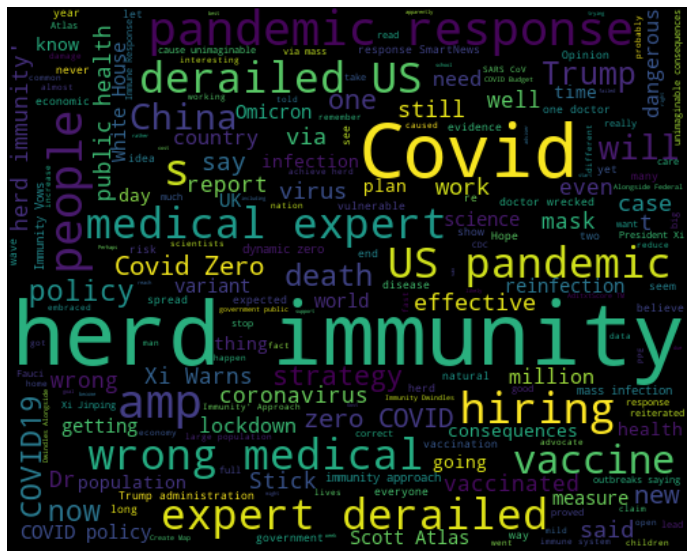

In [37]:
all_words = ' '.join( [data for data in df_clean['tweet_text']])
word_cloud = WordCloud(width=500, height=400, random_state=21, max_font_size = 100).generate(all_words)

plt.figure(figsize = (20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 3. Training BERT Model

In [ ]:
# Reading labelled data
df2 = pd.read_csv("labelled_data_cleaned.csv")
df2

In [242]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4229 entries, 0 to 4228
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  4229 non-null   object
 1   label       4229 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 66.2+ KB


In [247]:
df2['label'].value_counts()

1    1955
0    1527
2     747
Name: label, dtype: int64

## 3.1 Processing Data for Binary Classification

In [248]:
bi_df = df2[(df2.label==0) | (df2.label==2) ] # make it binary classification
bi_df.label.replace(2,1, inplace=True) # make it binary classification

/opt/workshop/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [249]:
# Data Imbalance
bi_df['label'].value_counts()

0    1527
1     747
Name: label, dtype: int64

In [250]:
pos_samples = bi_df[bi_df['label']==1]
# Making the negative lables equal to positive labels to prevent bias
neg_samples = bi_df[bi_df['label']==0].sample(len(pos_samples), random_state=42)

bal_bi_df = pd.concat([pos_samples, neg_samples])

In [251]:
bal_bi_df['label'].value_counts()

1    747
0    747
Name: label, dtype: int64

## 3.2 Splitting dataset into Train and Validation sets

In [252]:
train_df, val_df = train_test_split(bi_df, test_size=0.2,  random_state=42)

In [253]:
train_df['label'].value_counts()
val_df['label'].value_counts()

0    1213
1     606
Name: label, dtype: int64

0    314
1    141
Name: label, dtype: int64

## 3.3 Loading BERT classification model

In [148]:
ct_model = ClassificationModel('bert',
                            'digitalepidemiologylab/covid-twitter-bert',
                            num_labels=2,
                            use_cuda=False,
                            args={'overwrite_output_dir': True})

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifi

## 3.4 Model Training

In [149]:
%%time

ct_model.train_model(train_df=train_df, eval_df=val_df)

/opt/workshop/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:277: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


/opt/workshop/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/opt/workshop/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



CPU times: user 3h 45min 19s, sys: 4min 9s, total: 3h 49min 29s
Wall time: 19min 35s


## 3.5 Metrics of Model

In [150]:
def multi_F1(y_true, y_pred, average='macro'):
    return sklearn.metrics.f1_score(y_true=y_true, y_pred=y_pred, average=average)

def multi_classification_report(y_true, y_pred):
    return sklearn.metrics.classification_report(y_true=y_true, y_pred=y_pred)

In [151]:
%%time

result, model_outputs, wrong_predictions = ct_model.eval_model(val_df, f1=multi_F1);
print('f1 score = ',result['f1'])

/opt/workshop/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:750: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(



f1 score =  0.8580374297303068
CPU times: user 12min 40s, sys: 2.14 s, total: 12min 42s
Wall time: 51.3 s


In [152]:
%%time

result, model_outputs, wrong_predictions = ct_model.eval_model(val_df, report=multi_classification_report);
print('Classification Report: ', result['report'])


Classification Report:                precision    recall  f1-score   support

           0       0.93      0.88      0.91       314
           1       0.77      0.86      0.81       141

    accuracy                           0.87       455
   macro avg       0.85      0.87      0.86       455
weighted avg       0.88      0.87      0.88       455

CPU times: user 12min 21s, sys: 1.92 s, total: 12min 23s
Wall time: 49.4 s


# 4. Loading and Using Model for Predictions

## 4.1 Loading Model from outputs

In [38]:
ct_model = ClassificationModel('bert',
                            'outputs/',
                            num_labels=2,
                            use_cuda=False)

In [39]:
new_tweets = df_clean['tweet_text'].values

In [40]:
df_clean['tweet_text'].values

array(['Interview with renowned Oxford epidemiologist Dr. Sunetra Gupta pandemic viruses, population immunity amp the immunological landscape, how SARS CoV 2 is not all that unusual amp the perverse outcome of intervention, more. ',
       'RNA vaccine covid19 vaccine especially dangerous because the vaccine is directed at a old covid 19 spike protein that is no longer became extinct when the original covid 19 became extinct due herd immunity.This vaccine does not give protection . ',
       'With freedom day fast approaching, the Government is going for herd immunity #COVID19 #humour #KindleUnlimited ',
       'Opinion How one doctor wrecked the pandemic response ',
       "Marching between Skippy and James Topp is Dr Paul Alexander, the Trump Caputo science adviser who called for millions of Americans to be infected with Covid 19 to achieve herd immunity amp save the economy. Alexander dominated Topp's presser with 24 CPC MPs in Ottawa a week ago. ",
       'How one doctor wrecked th

In [41]:
tweet_list = new_tweets.tolist()

## 4.2 Running Predictions

In [42]:
new_result = ct_model.predict(tweet_list)
print(new_result[0])

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [43]:
# Saving predictions in a new column
df_clean['ML_label'] = new_result[0]

df_clean['ML_label'].value_counts()

0    246
1     34
Name: ML_label, dtype: int64

In [44]:
# Saving new data in csv
df_clean.to_csv('data_predictions_labelled.csv')

# 5. Sentiment Analysis

In [45]:
import collections

counter = collections.Counter(new_result[0])
counter

Counter({0: 246, 1: 34})

## 5.1 Bar Chart of Positive V/S Negative Sentiments

Text(0.5, 1.0, 'Sentiment Analysis')

Text(0.5, 0, 'Sentiments')

Text(0, 0.5, 'Number of Tweets')

<BarContainer object of 2 artists>

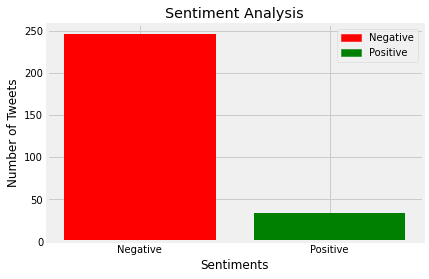

In [46]:
labels = ['Negative', 'Positive']
totals = [counter[0],counter[1]]
c = ['red', 'green']
handles = [plt.Rectangle((0,0),1,1, color=c[label]) for label in range(2)]
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments')
plt.ylabel('Number of Tweets')
plt.legend(handles, labels)
plt.bar(labels, totals,color=c)

## 5.2 Scatter plot of Tweet Sentiment Analysis Over Date

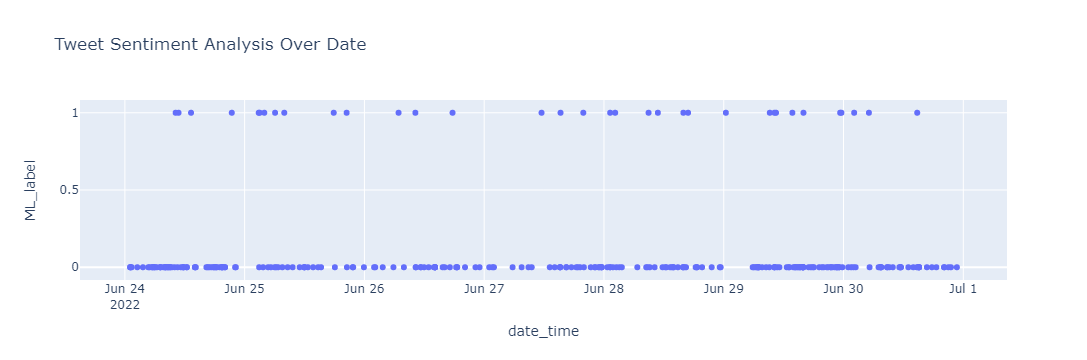

In [47]:
import plotly.express as px
#px.init_notebook_mode()
added_df = pd.read_csv("data_predictions_labelled.csv")

fig = px.scatter(added_df, x='date_time', y='ML_label', hover_data=['tweet_text'], title='Tweet Sentiment Analysis Over Date')
fig.show()

## 5.3 TextBlob Sentiment Analysis

In [50]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [51]:
#Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [52]:
added_df['subjectivity'] = added_df['tweet_text'].apply(getSubjectivity)
added_df['polarity'] = added_df['tweet_text'].apply(getPolarity)
added_df


Unnamed: 0         tweet_id_str                  date_time  \
0             0  1542639871981920256  2022-06-30 22:43:01+00:00   
1             1  1542621979496402952  2022-06-30 21:31:55+00:00   
2             2  1542613809285795840  2022-06-30 20:59:27+00:00   
3             3  1542601823202119681  2022-06-30 20:11:49+00:00   
4             4  1542600827730157568  2022-06-30 20:07:52+00:00   
..          ...                  ...                        ...   
275         275  1540160082440241152  2022-06-24 02:29:13+00:00   
276         276  1540143064475639808  2022-06-24 01:21:35+00:00   
277         277  1540139913567301633  2022-06-24 01:09:04+00:00   
278         278  1540138957220073473  2022-06-24 01:05:16+00:00   
279         279  1540138337050062848  2022-06-24 01:02:48+00:00   

                        location  \
0              Pennsylvania, USA   
1                  New York, USA   
2                     Wirral, UK   
3    BC, Canada(formerly, Calif)   
4                            NaN   
..                           ...   
275                New York, USA   
276              California, USA   
277                 Portland, OR   
278            St Petersburg, FL   
279    Seattle, WA, USA (mostly)   

                                            tweet_text  ML_label  \
0    Interview with renowned Oxford epidemiologist ...         0   
1    RNA vaccine covid19 vaccine especially dangero...         0   
2    With freedom day fast approaching, the Governm...         0   
3    Opinion How one doctor wrecked the pandemic re...         0   
4    Marching between Skippy and James Topp is Dr P...         0   
..                                                 ...       ...   
275   Johnson government used the pandemic to imple...         0   
276  How hiring the wrong medical expert derailed U...         0   
277  How hiring the wrong medical expert derailed U...         0   
278  Trump's COVID Task Force Leader Pushed Back on...         0   
279  How hiring the wrong medical expert derailed U...         0   

     subjectivity  polarity  
0        0.750000  0.350000  
1        0.587500 -0.241667  
2        0.300000  0.100000  
3        0.000000  0.000000  
4        0.000000  0.000000  
..            ...       ...  
275      0.327778 -0.025694  
276      0.450000 -0.250000  
277      0.450000 -0.250000  
278      0.000000  0.000000  
279      0.350000 -0.125000  

[280 rows x 8 columns]

In [53]:
def get_sentiment_label(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'    

In [54]:
added_df['TBsentiment'] = added_df['polarity'].apply(get_sentiment_label)
added_df

Unnamed: 0         tweet_id_str                  date_time  \
0             0  1542639871981920256  2022-06-30 22:43:01+00:00   
1             1  1542621979496402952  2022-06-30 21:31:55+00:00   
2             2  1542613809285795840  2022-06-30 20:59:27+00:00   
3             3  1542601823202119681  2022-06-30 20:11:49+00:00   
4             4  1542600827730157568  2022-06-30 20:07:52+00:00   
..          ...                  ...                        ...   
275         275  1540160082440241152  2022-06-24 02:29:13+00:00   
276         276  1540143064475639808  2022-06-24 01:21:35+00:00   
277         277  1540139913567301633  2022-06-24 01:09:04+00:00   
278         278  1540138957220073473  2022-06-24 01:05:16+00:00   
279         279  1540138337050062848  2022-06-24 01:02:48+00:00   

                        location  \
0              Pennsylvania, USA   
1                  New York, USA   
2                     Wirral, UK   
3    BC, Canada(formerly, Calif)   
4                            NaN   
..                           ...   
275                New York, USA   
276              California, USA   
277                 Portland, OR   
278            St Petersburg, FL   
279    Seattle, WA, USA (mostly)   

                                            tweet_text  ML_label  \
0    Interview with renowned Oxford epidemiologist ...         0   
1    RNA vaccine covid19 vaccine especially dangero...         0   
2    With freedom day fast approaching, the Governm...         0   
3    Opinion How one doctor wrecked the pandemic re...         0   
4    Marching between Skippy and James Topp is Dr P...         0   
..                                                 ...       ...   
275   Johnson government used the pandemic to imple...         0   
276  How hiring the wrong medical expert derailed U...         0   
277  How hiring the wrong medical expert derailed U...         0   
278  Trump's COVID Task Force Leader Pushed Back on...         0   
279  How hiring the wrong medical expert derailed U...         0   

     subjectivity  polarity TBsentiment  
0        0.750000  0.350000    Positive  
1        0.587500 -0.241667    Negative  
2        0.300000  0.100000    Positive  
3        0.000000  0.000000     Neutral  
4        0.000000  0.000000     Neutral  
..            ...       ...         ...  
275      0.327778 -0.025694    Negative  
276      0.450000 -0.250000    Negative  
277      0.450000 -0.250000    Negative  
278      0.000000  0.000000     Neutral  
279      0.350000 -0.125000    Negative  

[280 rows x 9 columns]

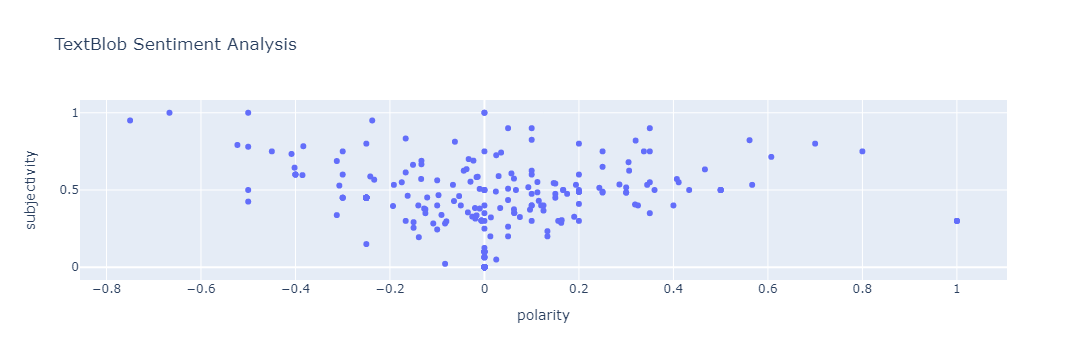

In [56]:
fig = px.scatter(added_df, x="polarity", y="subjectivity", hover_data=['tweet_text'],
                 title="TextBlob Sentiment Analysis")

fig.show()

## 5.4 VADER Sentiment Analysis

In [57]:
analyser = SentimentIntensityAnalyzer()

def get_vaderCompoundPolarity(text):
    return analyser.polarity_scores(text)['compound']
    
added_df['vader_compound'] = added_df['tweet_text'].apply(get_vaderCompoundPolarity)
added_df

Unnamed: 0         tweet_id_str                  date_time  \
0             0  1542639871981920256  2022-06-30 22:43:01+00:00   
1             1  1542621979496402952  2022-06-30 21:31:55+00:00   
2             2  1542613809285795840  2022-06-30 20:59:27+00:00   
3             3  1542601823202119681  2022-06-30 20:11:49+00:00   
4             4  1542600827730157568  2022-06-30 20:07:52+00:00   
..          ...                  ...                        ...   
275         275  1540160082440241152  2022-06-24 02:29:13+00:00   
276         276  1540143064475639808  2022-06-24 01:21:35+00:00   
277         277  1540139913567301633  2022-06-24 01:09:04+00:00   
278         278  1540138957220073473  2022-06-24 01:05:16+00:00   
279         279  1540138337050062848  2022-06-24 01:02:48+00:00   

                        location  \
0              Pennsylvania, USA   
1                  New York, USA   
2                     Wirral, UK   
3    BC, Canada(formerly, Calif)   
4                            NaN   
..                           ...   
275                New York, USA   
276              California, USA   
277                 Portland, OR   
278            St Petersburg, FL   
279    Seattle, WA, USA (mostly)   

                                            tweet_text  ML_label  \
0    Interview with renowned Oxford epidemiologist ...         0   
1    RNA vaccine covid19 vaccine especially dangero...         0   
2    With freedom day fast approaching, the Governm...         0   
3    Opinion How one doctor wrecked the pandemic re...         0   
4    Marching between Skippy and James Topp is Dr P...         0   
..                                                 ...       ...   
275   Johnson government used the pandemic to imple...         0   
276  How hiring the wrong medical expert derailed U...         0   
277  How hiring the wrong medical expert derailed U...         0   
278  Trump's COVID Task Force Leader Pushed Back on...         0   
279  How hiring the wrong medical expert derailed U...         0   

     subjectivity  polarity TBsentiment  vader_compound  
0        0.750000  0.350000    Positive         -0.4215  
1        0.587500 -0.241667    Negative         -0.5095  
2        0.300000  0.100000    Positive          0.8074  
3        0.000000  0.000000     Neutral          0.0000  
4        0.000000  0.000000     Neutral          0.0000  
..            ...       ...         ...             ...  
275      0.327778 -0.025694    Negative         -0.6872  
276      0.450000 -0.250000    Negative         -0.6705  
277      0.450000 -0.250000    Negative         -0.6705  
278      0.000000  0.000000     Neutral          0.0000  
279      0.350000 -0.125000    Negative         -0.8126  

[280 rows x 10 columns]

In [58]:
added_df['VADERsentiment'] = added_df['vader_compound'].apply(get_sentiment_label)
added_df

Unnamed: 0         tweet_id_str                  date_time  \
0             0  1542639871981920256  2022-06-30 22:43:01+00:00   
1             1  1542621979496402952  2022-06-30 21:31:55+00:00   
2             2  1542613809285795840  2022-06-30 20:59:27+00:00   
3             3  1542601823202119681  2022-06-30 20:11:49+00:00   
4             4  1542600827730157568  2022-06-30 20:07:52+00:00   
..          ...                  ...                        ...   
275         275  1540160082440241152  2022-06-24 02:29:13+00:00   
276         276  1540143064475639808  2022-06-24 01:21:35+00:00   
277         277  1540139913567301633  2022-06-24 01:09:04+00:00   
278         278  1540138957220073473  2022-06-24 01:05:16+00:00   
279         279  1540138337050062848  2022-06-24 01:02:48+00:00   

                        location  \
0              Pennsylvania, USA   
1                  New York, USA   
2                     Wirral, UK   
3    BC, Canada(formerly, Calif)   
4                            NaN   
..                           ...   
275                New York, USA   
276              California, USA   
277                 Portland, OR   
278            St Petersburg, FL   
279    Seattle, WA, USA (mostly)   

                                            tweet_text  ML_label  \
0    Interview with renowned Oxford epidemiologist ...         0   
1    RNA vaccine covid19 vaccine especially dangero...         0   
2    With freedom day fast approaching, the Governm...         0   
3    Opinion How one doctor wrecked the pandemic re...         0   
4    Marching between Skippy and James Topp is Dr P...         0   
..                                                 ...       ...   
275   Johnson government used the pandemic to imple...         0   
276  How hiring the wrong medical expert derailed U...         0   
277  How hiring the wrong medical expert derailed U...         0   
278  Trump's COVID Task Force Leader Pushed Back on...         0   
279  How hiring the wrong medical expert derailed U...         0   

     subjectivity  polarity TBsentiment  vader_compound VADERsentiment  
0        0.750000  0.350000    Positive         -0.4215       Negative  
1        0.587500 -0.241667    Negative         -0.5095       Negative  
2        0.300000  0.100000    Positive          0.8074       Positive  
3        0.000000  0.000000     Neutral          0.0000        Neutral  
4        0.000000  0.000000     Neutral          0.0000        Neutral  
..            ...       ...         ...             ...            ...  
275      0.327778 -0.025694    Negative         -0.6872       Negative  
276      0.450000 -0.250000    Negative         -0.6705       Negative  
277      0.450000 -0.250000    Negative         -0.6705       Negative  
278      0.000000  0.000000     Neutral          0.0000        Neutral  
279      0.350000 -0.125000    Negative         -0.8126       Negative  

[280 rows x 11 columns]

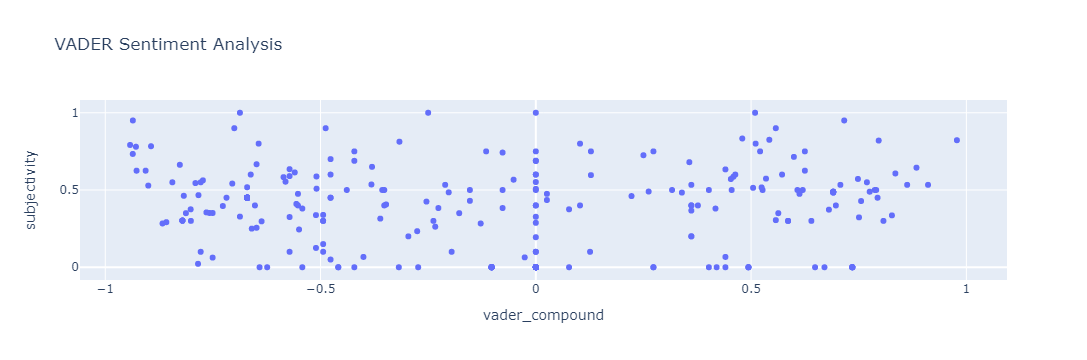

In [59]:
fig = px.scatter(added_df, x="vader_compound", y="subjectivity", hover_data=['tweet_text'],
                 title="VADER Sentiment Analysis")

fig.show()

In [60]:
added_df.to_csv('sentiments_data.csv')

## 5.5 WordCloud of Negative Tweets

In [62]:
temp_all = []
for i in df_pp['tweet_text']:
    temp = tokenizer.tokenize(i)
    temp = [token.strip() for token in temp]
    temp_all.extend(temp)

In [63]:
words = pd.DataFrame(data=temp_all, columns=['word'])
words

word
0          interview
1           renowned
2             oxford
3     epidemiologist
4                dr.
...              ...
5253         testing
5254               ,
5255           would
5256            goal
5257               .

[5258 rows x 1 columns]

In [64]:
words['vader_compound'] = words['word'].apply(get_vaderCompoundPolarity)
words['VADERsentiment'] = words['vader_compound'].apply(get_sentiment_label)

words['VADERsentiment'].value_counts()

Neutral     4634
Negative     348
Positive     276
Name: VADERsentiment, dtype: int64

In [65]:
neg_words = words[words.VADERsentiment=='Negative'] 
neg_words

word  vader_compound VADERsentiment
17     perverse         -0.4215       Negative
27    dangerous         -0.4767       Negative
79     infected         -0.4939       Negative
111    infected         -0.4939       Negative
141       wrong         -0.4767       Negative
...         ...             ...            ...
5209      wrong         -0.4767       Negative
5212   derailed         -0.3400       Negative
5229      wrong         -0.4767       Negative
5232   derailed         -0.3400       Negative
5252      block         -0.4404       Negative

[348 rows x 3 columns]

In [66]:
pos_words = words[words.VADERsentiment=='Positive']
pos_words

word  vader_compound VADERsentiment
37       original          0.3182       Positive
48        freedom          0.6369       Positive
57        #humour          0.4767       Positive
83           save          0.4939       Positive
135          hope          0.4404       Positive
...           ...             ...            ...
5108  significant          0.2023       Positive
5113  substantial          0.2023       Positive
5166         joke          0.2960       Positive
5168        funny          0.4404       Positive
5185       wealth          0.4939       Positive

[276 rows x 3 columns]

<Figure size 1440x720 with 0 Axes>

(-0.5, 499.5, 399.5, -0.5)

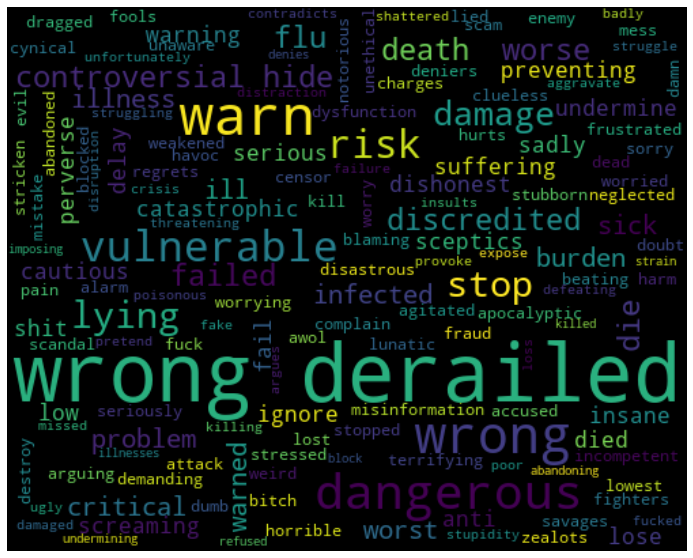

In [67]:
all_words = ' '.join( [data for data in neg_words['word']])
word_cloud = WordCloud(width=500, height=400, random_state=21, max_font_size = 100,
                       stopwords=stopwords).generate(all_words)

plt.figure(figsize = (20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 5.6 WordCloud of Negative Tweets

<Figure size 1440x720 with 0 Axes>

(-0.5, 499.5, 399.5, -0.5)

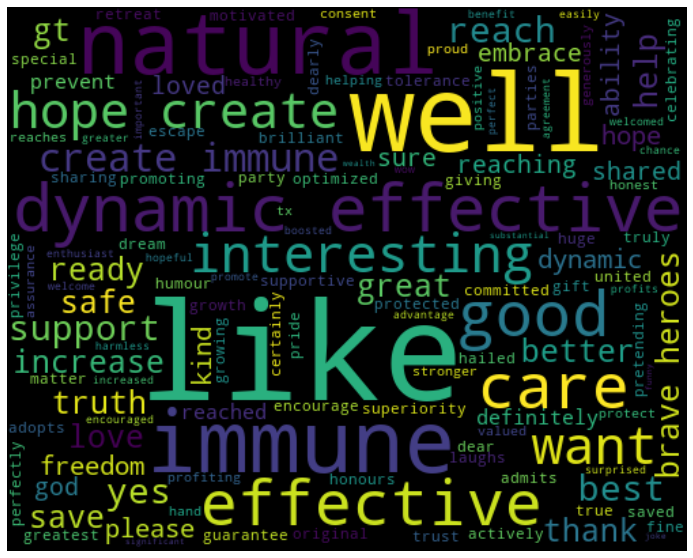

In [68]:
all_words = ' '.join( [data for data in pos_words['word']])
word_cloud = WordCloud(width=500, height=400, random_state=21, max_font_size = 100,
                       stopwords=stopwords).generate(all_words)

plt.figure(figsize = (20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 6. Additional Challenge From Tutorial 2

> Given the labels provided for each tweet in the 'label' column (which we will consider to be the correct sentiment of each tweet), investigate the accuracy of the TextBlob and VADER sentiment analysis tools. 
> 1) For what percentage of tweets did the TextBlob and VADER tools correctly predict the sentiment? Which model performs better?

In [76]:
# Reading labelled data
df_labelled = pd.read_csv('labelled_data_cleaned.csv')

# Calculating subjectivity, polarity and TextBlob sentiment
df_labelled['subjectivity'] = df_labelled['tweet_text'].apply(getSubjectivity)
df_labelled['polarity'] = df_labelled['tweet_text'].apply(getPolarity)

# Calculating Vader Compound
df_labelled['vader_compound'] = df_labelled['tweet_text'].apply(get_vaderCompoundPolarity)

# Getting labels based on polarity and compound
df_labelled['TBsentiment'] = df_labelled['polarity'].apply(get_sentiment_label)
df_labelled['VADERsentiment'] = df_labelled['vader_compound'].apply(get_sentiment_label)

## 6.2 Checking number of accurate TBsentiments outcomes

In [77]:
records = len(df_labelled)

In [78]:
df_labelled

tweet_text  label  subjectivity  \
0     Jesus Ive actually spent all the money I saved...      1      0.083333   
1     Coronavirus and throat cancer looking after yo...      1      0.200000   
2     Me sick at home in Houston w Covid symptoms ri...      1      0.696429   
3     Coronavirus pandemic prompts record drop in gl...      1      0.000000   
4     Coronavirus How can we make postpandemic citie...      1      0.125000   
...                                                 ...    ...           ...   
4224  Was recently tested for #coronavirus not at al...      1      0.643333   
4225  Despite the Lockdown, Crises, Vera Lynn We'll ...      1      0.000000   
4226  Due to COVID and mandatory face masks, million...      0      0.555000   
4227  Something someone said to me in regards to me ...      0      0.644444   
4228  So someone who saw my tweet about the 5k Melbo...      1      0.000000   

      polarity  vader_compound TBsentiment VADERsentiment  
0    -0.050000          0.4215    Negative       Positive  
1    -0.100000         -0.8689    Negative       Negative  
2    -0.214286         -0.5106    Negative       Negative  
3     0.000000         -0.2732     Neutral       Negative  
4     0.000000          0.6199     Neutral       Positive  
...        ...             ...         ...            ...  
4224  0.221667          0.8439    Positive       Positive  
4225  0.000000          0.0000     Neutral        Neutral  
4226 -0.038333         -0.4389    Negative       Negative  
4227  0.008333          0.7889    Positive       Positive  
4228  0.300000          0.7426    Positive       Positive  

[4229 rows x 7 columns]

In [79]:
correct_label_TB = 0
incorrect_label_TB = 0
for x in range(records):
    if (df_labelled.loc[x]['label'] == 1) and (df_labelled.loc[x]['TBsentiment'] == 'Neutral'):
        correct_label_TB += 1
    elif (df_labelled.loc[x]['label'] == 0) and (df_labelled.loc[x]['TBsentiment'] == 'Negative'):
        correct_label_TB += 1        
    elif (df_labelled.loc[x]['label'] == 2) and (df_labelled.loc[x]['TBsentiment'] == 'Positive'):
        correct_label_TB += 1

    else:
        incorrect_label_TB += 1

In [80]:
print('Number of correct TextBlob labels: ' + str(correct_label_TB))
print('Number of incorrect TextBlob labels: ' + str(incorrect_label_TB))

Number of correct TextBlob labels: 2023
Number of incorrect TextBlob labels: 2206


In [84]:
percent_accuracy_tb = (correct_label_TB/records) * 100
print('Accuracy of TextBlob: ' + str(percent_accuracy_tb) + ' %')

Accuracy of TextBlob: 47.8363679356822 %


## 6.2 Checking number of accuracies of VADERsentiment

In [85]:
correct_label_vader = 0
incorrect_label_vader = 0
for x in range(records):
    if (df_labelled.loc[x]['label'] == 1) and (df_labelled.loc[x]['VADERsentiment'] == 'Neutral'):
        correct_label_vader += 1
    elif (df_labelled.loc[x]['label'] == 0) and (df_labelled.loc[x]['VADERsentiment'] == 'Negative'):
        correct_label_vader += 1        
    elif (df_labelled.loc[x]['label'] == 2) and (df_labelled.loc[x]['VADERsentiment'] == 'Positive'):
        correct_label_vader += 1
    else:
        incorrect_label_vader += 1

In [86]:
print('Number of correct VADER labels: ' + str(correct_label_vader))
print('Number of incorrect VADER labels: ' + str(incorrect_label_vader))

Number of correct VADER labels: 2124
Number of incorrect VADER labels: 2105


In [88]:
percent_accuracy_vader = (correct_label_vader/records) * 100
print('Accuracy of Vader: ' + str(percent_accuracy_vader) + ' %')

Accuracy of Vader: 50.224639394655945 %
